# EDA

Ya con los datos completos se procede a realizar el analisis exploratorio de la base de datos.

In [1]:
# Importacion de librerías
import pandas as pd
import numpy as np
import janitor
import matplotlib.pyplot as plt
import seaborn as sns

import os


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
#import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
#from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


#Permite ver en los resultados todas las columnas y las filas, Grupo Marianita, Herdiz, Erick
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')


In [4]:
path = "../data/interim/"
archivo = "datos_completos.csv"

data = pd.read_csv(os.path.join(path,archivo),sep=',')
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [5]:
df = data.clean_names()
df.shape

(7032, 21)

In [6]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   seniorcitizen     7032 non-null   int64  
 3   partner           7032 non-null   object 
 4   dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   phoneservice      7032 non-null   object 
 7   multiplelines     7032 non-null   object 
 8   internetservice   7032 non-null   object 
 9   onlinesecurity    7032 non-null   object 
 10  onlinebackup      7032 non-null   object 
 11  deviceprotection  7032 non-null   object 
 12  techsupport       7032 non-null   object 
 13  streamingtv       7032 non-null   object 
 14  streamingmovies   7032 non-null   object 
 15  contract          7032 non-null   object 
 16  paperlessbilling  7032 non-null   object 


### 1° Variable Objetivo churn

Cambiaremos los valores de la variable Churn a los valores 1 y 0.
Utilizar la función replace() con un diccionario de mapeo

In [9]:
# 1° Cambiaremos los valores de la variable Churn a los valores 1 y 0
# Utilizar la función replace() con un diccionario de mapeo

df['churn'] = df['churn'].replace({'Yes': 1, 'No': 0})

In [10]:
# diatribución de varible Churn
df['churn'].value_counts()

churn
0    5163
1    1869
Name: count, dtype: int64

In [12]:
print('Distribución del variable churn')
df['churn'].value_counts('%')*100

Distribución del variable churn


churn
0   73.42
1   26.58
Name: proportion, dtype: float64

Representación Gráfica de variable objetivo 'churn'

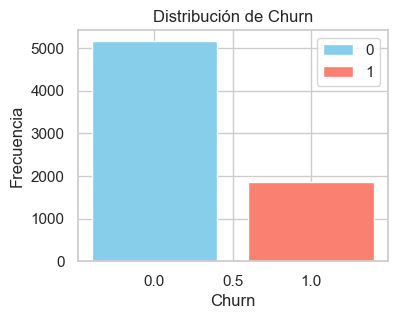

In [40]:
# Gráfico de la variable Churn
plt.figure(figsize=(4, 3))

churn_values = df['churn'].value_counts()
churn_values.values

plt.bar(churn_values.index, churn_values.values, color=['skyblue', 'salmon'], label = churn_values.index)
# Configurar etiquetas y título
plt.xlabel('Churn')
plt.ylabel('Frecuencia')
plt.title('Distribución de Churn')
plt.legend(churn_values.index)
plt.savefig(f'../reports/figures/Distribución de Churn.png') #guardar imagen
# Mostrar el gráfico
plt.show()

### 2° Variables numéricas

In [17]:
var_numericas = list(df.select_dtypes(include='number'))
var_numericas

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'churn']

A la función habitual de python describe(), se adjunta el coeficiente de variación CV y porcentaje de valores nulos en el resumen.

In [20]:
#funcion describe con CV
def describe_con_CV(df, columnas_numericas):
    """Incluye Porc. Nulos y CV a resumen describe

    Args:
        df: dataframe
        columnas_numericas
    
    Return:
        describe con Porc. nulos y CV
    """
    df_describe = df[columnas_numericas].describe()
    #Porcentaje de valores nulos
    porcentaje_nulos = df[columnas_numericas].isnull().mean()*100
    porcentaje_nulos.name = 'Porc_nulos'

    # Calcular el coeficiente de variación (CV)
    # CV = (Desviación estándar / Media)
    cv = (df[columnas_numericas].std() / df[columnas_numericas].mean()) * 100
    cv.name = 'coef_var'

    # Convertir las métricas calculadas en DataFrames
    porcentaje_nulos_df = pd.DataFrame(porcentaje_nulos).T
    cv_df = pd.DataFrame(cv).T

    # Concatenar el resumen original con las nuevas filas
    describe_nuevo = pd.concat([df_describe, porcentaje_nulos_df, cv_df])
    return describe_nuevo


In [22]:
describe_nuevo = describe_con_CV(df, var_numericas)
describe_nuevo

,seniorcitizen,tenure,monthlycharges,totalcharges,churn
count,7032.00,7032.00,7032.00,7032.00,7032.00
mean,0.16,32.42,64.80,2283.30,0.27
std,0.37,24.55,30.09,2266.77,0.44
min,0.00,1.00,18.25,18.80,0.00
25%,0.00,9.00,35.59,401.45,0.00
50%,0.00,29.00,70.35,1397.47,0.00
75%,0.00,55.00,89.86,3794.74,1.00
max,1.00,72.00,118.75,8684.80,1.00
Porc_nulos,0.00,0.00,0.00,0.00,0.00
coef_var,227.12,75.71,46.43,99.28,166.22


In [23]:
def describe_con_CV(df, columnas_numericas):
    """Incluye Porc. Nulos, CV, curtosis y asimetría al resumen describe

    Args:
        df: dataframe
        columnas_numericas: lista de nombres de columnas numéricas

    Return:
        describe con Porc. nulos, CV, curtosis y asimetría
    """
    # Calcular el resumen describe
    df_describe = df[columnas_numericas].describe()

    # Porcentaje de valores nulos
    porcentaje_nulos = df[columnas_numericas].isnull().mean() * 100
    porcentaje_nulos.name = 'Porc_nulos'

    # Calcular el coeficiente de variación (CV)
    # CV = (Desviación estándar / Media) * 100
    cv = (df[columnas_numericas].std() / df[columnas_numericas].mean()) * 100
    cv.name = 'coef_var'

    # Calcular la curtosis
    curtosis = df[columnas_numericas].kurtosis()
    curtosis.name = 'curtosis'

    # Calcular la asimetría
    asimetria = df[columnas_numericas].skew()
    asimetria.name = 'asimetria'

    # Convertir las métricas calculadas en DataFrames
    porcentaje_nulos_df = pd.DataFrame(porcentaje_nulos).T
    cv_df = pd.DataFrame(cv).T
    curtosis_df = pd.DataFrame(curtosis).T
    asimetria_df = pd.DataFrame(asimetria).T

    # Concatenar el resumen original con las nuevas filas
    describe_nuevo = pd.concat([df_describe, porcentaje_nulos_df, cv_df, curtosis_df, asimetria_df])

    return describe_nuevo



In [24]:

resumen_describe = describe_con_CV(df, var_numericas)
print(resumen_describe)


            seniorcitizen  tenure  monthlycharges  totalcharges   churn
count             7032.00 7032.00         7032.00       7032.00 7032.00
mean                 0.16   32.42           64.80       2283.30    0.27
std                  0.37   24.55           30.09       2266.77    0.44
min                  0.00    1.00           18.25         18.80    0.00
25%                  0.00    9.00           35.59        401.45    0.00
50%                  0.00   29.00           70.35       1397.47    0.00
75%                  0.00   55.00           89.86       3794.74    1.00
max                  1.00   72.00          118.75       8684.80    1.00
Porc_nulos           0.00    0.00            0.00          0.00    0.00
coef_var           227.12   75.71           46.43         99.28  166.22
curtosis             1.35   -1.39           -1.26         -0.23   -0.88
asimetria            1.83    0.24           -0.22          0.96    1.06


Interpretación

Asimetría:

Positiva: Cola larga a la derecha. (Ej. ingresos altos de pocos individuos)

Negativa: Cola larga a la izquierda. (Ej. edades de jubilación temprana de pocos individuos)

Cero: Distribución simétrica. (Ej. alturas en una población)

Curtosis:

Positiva: Colas pesadas, pico alto y estrecho. (Ej. retornos de inversión)

Negativa: Colas ligeras, distribución plana. (Ej. notas de exámenes)

Cero: Distribución normal. (Ej. alturas en una población)


### Representaciones gráficas de las variables numéricas

In [26]:
var_numericas

['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'churn']

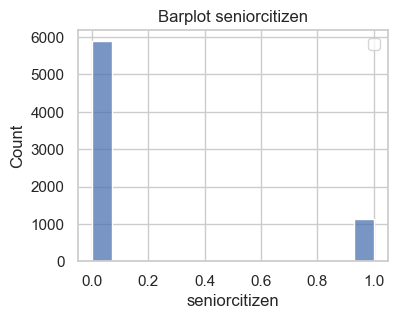

In [41]:
variable = 'seniorcitizen'
# Configurar el estilo y el tamaño del gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(4, 3))

sns.histplot(df[variable],  )
plt.title(f'Barplot {variable}')
plt.xlabel(variable)
plt.ylabel('Count')
plt.legend(title='')
plt.savefig(f'../reports/figures/Barplot {variable}.png')
plt.show()

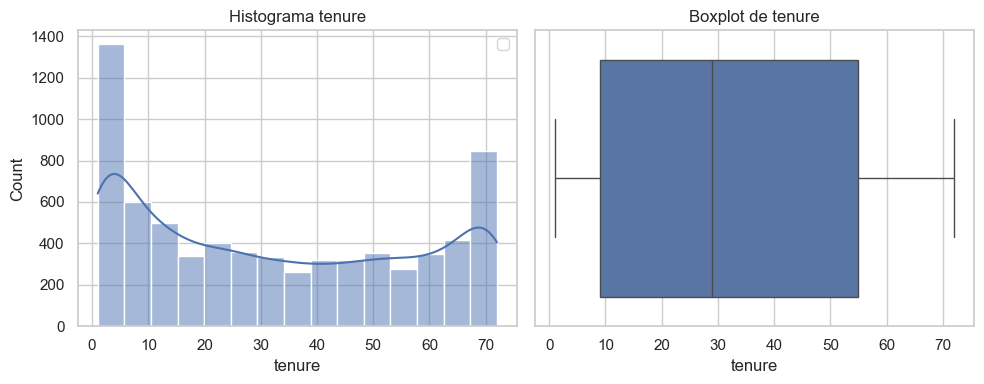

In [43]:
variable = 'tenure'
#target = 'Churn' # debe ser categorica 
# Configurar el estilo y el tamaño del gráfico
sns.set(style="whitegrid")
# Crear una figura con dos subgráficos (histograma y boxplot)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df[variable], kde=True) #hue=target 
plt.title(f'Histograma {variable}')
plt.xlabel(variable)
plt.ylabel('Count')
plt.legend(title='')

# Subgráfico 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=variable) #, y="class") #, x='Churn'
plt.title(f'Boxplot de {variable}')
plt.xlabel(f'{variable}')
plt.ylabel('')
plt.savefig(f'../reports/figures/Histograma-Boxplot {variable}.png')
# Mostrar los gráficos
plt.tight_layout()
plt.show()

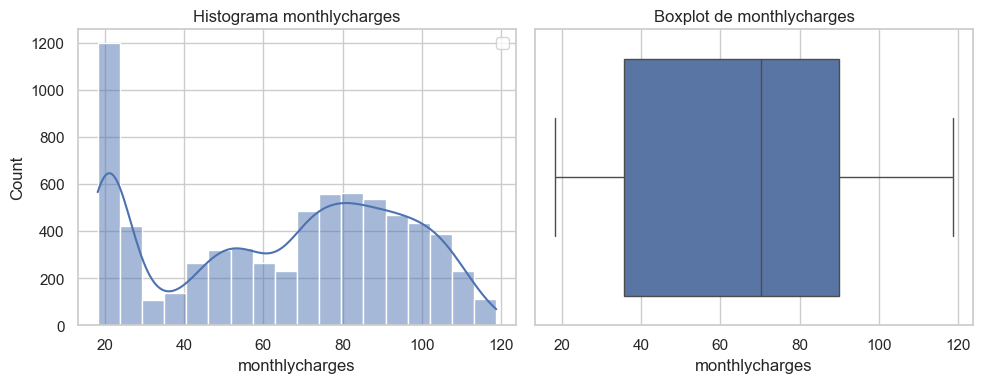

In [44]:
variable = 'monthlycharges'
#target = 'Churn' # debe ser categorica 

# Configurar el estilo y el tamaño del gráfico
sns.set(style="whitegrid")
# Crear una figura con dos subgráficos (histograma y boxplot)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df[variable], kde=True) #hue=target 
plt.title(f'Histograma {variable}')
plt.xlabel(variable)
plt.ylabel('Count')
plt.legend(title='')

# Subgráfico 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=variable) #, y="class") #, x='Churn'
plt.title(f'Boxplot de {variable}')
plt.xlabel(f'{variable}')
plt.ylabel('')
plt.savefig(f'../reports/figures/Histograma-Boxplot {variable}.png')
# Mostrar los gráficos
plt.tight_layout()
plt.show()

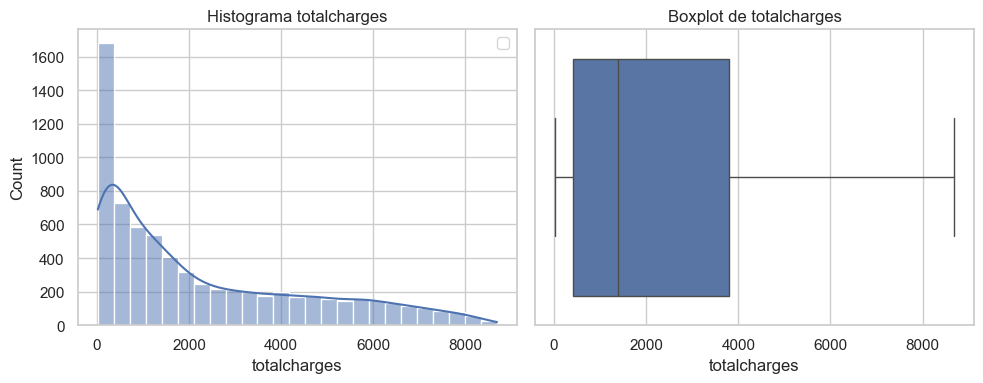

In [45]:
variable = 'totalcharges'
#target = 'Churn' # debe ser categorica 

# Configurar el estilo y el tamaño del gráfico
sns.set(style="whitegrid")
# Crear una figura con dos subgráficos (histograma y boxplot)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df[variable], kde=True) #hue=target 
plt.title(f'Histograma {variable}')
plt.xlabel(variable)
plt.ylabel('Count')
plt.legend(title='')

# Subgráfico 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x=variable) #, y="class") #, x='Churn'
plt.title(f'Boxplot de {variable}')
plt.xlabel(f'{variable}')
plt.ylabel('')
plt.savefig(f'../reports/figures/Histograma-Boxplot {variable}.png')
# Mostrar los gráficos
plt.tight_layout()
plt.show()

### 3° Variables Categóricas

In [31]:
var_categoricas = list(df.select_dtypes('object'))
var_categoricas

['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod']

Valores únicos en la columna

In [32]:
for columna in var_categoricas[1:]:
    valores_unicos = df[columna].unique()
    print(f"Valores únicos en la columna '{columna}': {valores_unicos}")

Valores únicos en la columna 'gender': ['Female' 'Male']
Valores únicos en la columna 'partner': ['Yes' 'No']
Valores únicos en la columna 'dependents': ['No' 'Yes']
Valores únicos en la columna 'phoneservice': ['No' 'Yes']
Valores únicos en la columna 'multiplelines': ['No phone service' 'No' 'Yes']
Valores únicos en la columna 'internetservice': ['DSL' 'Fiber optic' 'No']
Valores únicos en la columna 'onlinesecurity': ['No' 'Yes' 'No internet service']
Valores únicos en la columna 'onlinebackup': ['Yes' 'No' 'No internet service']
Valores únicos en la columna 'deviceprotection': ['No' 'Yes' 'No internet service']
Valores únicos en la columna 'techsupport': ['No' 'Yes' 'No internet service']
Valores únicos en la columna 'streamingtv': ['No' 'Yes' 'No internet service']
Valores únicos en la columna 'streamingmovies': ['No' 'Yes' 'No internet service']
Valores únicos en la columna 'contract': ['Month-to-month' 'One year' 'Two year']
Valores únicos en la columna 'paperlessbilling': ['Yes

Distribución de varibales categóricas

In [35]:
for var in var_categoricas[1:]:
    print (df.groupby(var)[var].count())
    print("-----")

gender
Female    3483
Male      3549
Name: gender, dtype: int64
-----
partner
No     3639
Yes    3393
Name: partner, dtype: int64
-----
dependents
No     4933
Yes    2099
Name: dependents, dtype: int64
-----
phoneservice
No      680
Yes    6352
Name: phoneservice, dtype: int64
-----
multiplelines
No                  3385
No phone service     680
Yes                 2967
Name: multiplelines, dtype: int64
-----
internetservice
DSL            2416
Fiber optic    3096
No             1520
Name: internetservice, dtype: int64
-----
onlinesecurity
No                     3497
No internet service    1520
Yes                    2015
Name: onlinesecurity, dtype: int64
-----
onlinebackup
No                     3087
No internet service    1520
Yes                    2425
Name: onlinebackup, dtype: int64
-----
deviceprotection
No                     3094
No internet service    1520
Yes                    2418
Name: deviceprotection, dtype: int64
-----
techsupport
No                     3472
No intern

Representación gráfica de las distribuciones de cada variable categórica, respecto a la variable objetivo 'churn' 

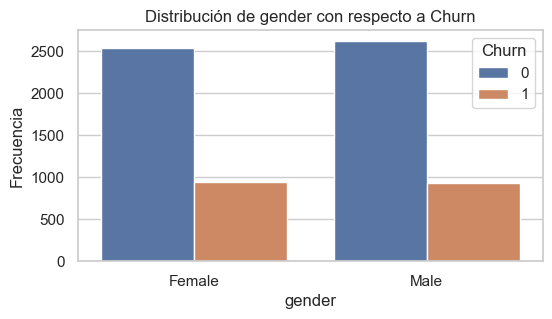

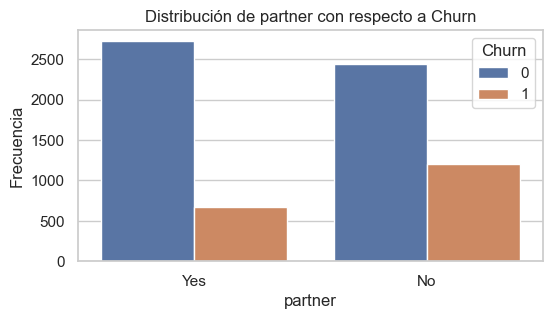

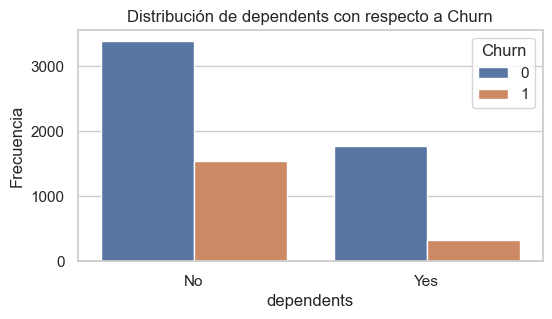

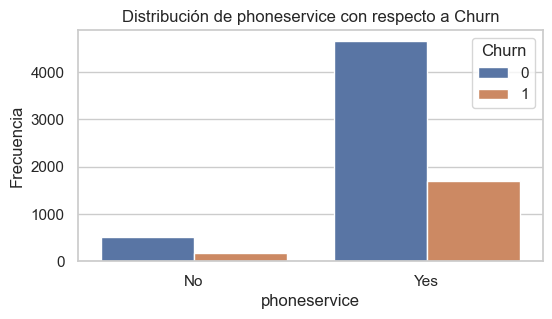

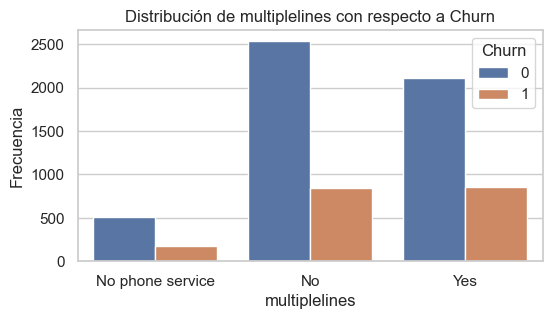

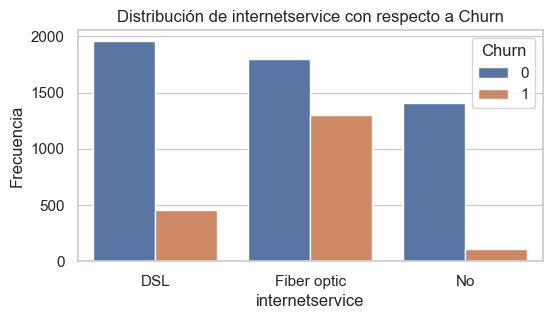

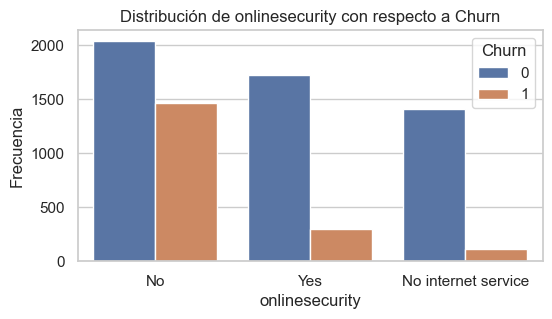

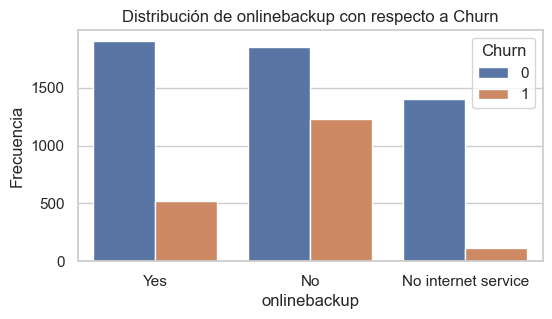

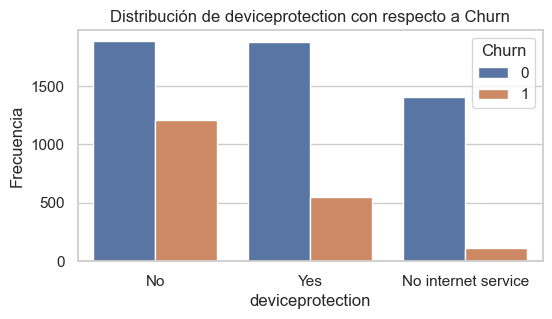

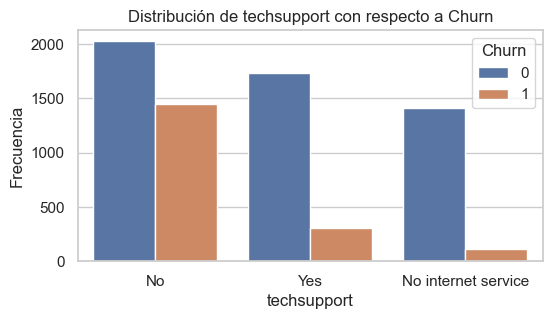

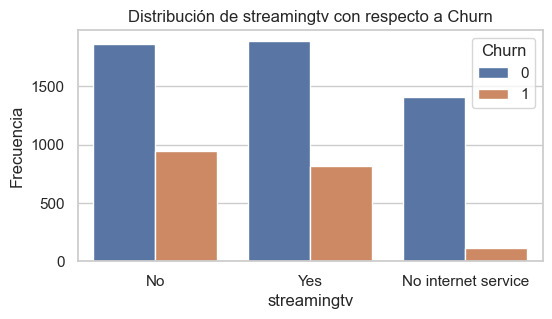

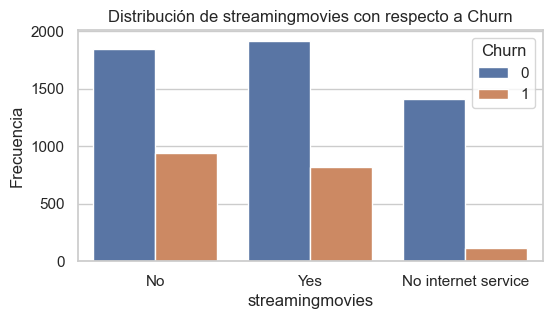

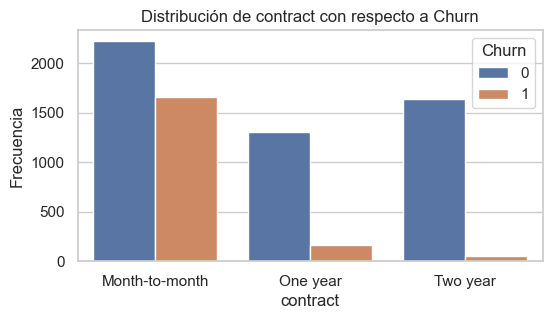

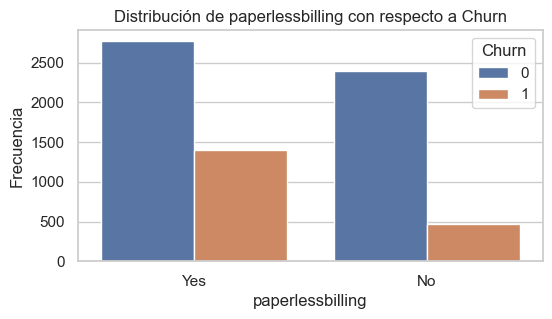

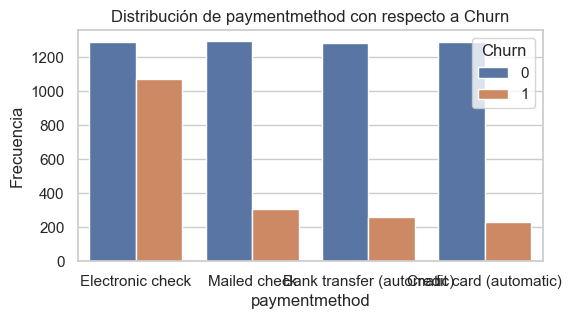

In [46]:
for col in var_categoricas[1:]:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='churn')
    plt.title(f'Distribución de {col} con respecto a Churn')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=0)
    plt.legend(title='Churn', loc='upper right')
    plt.savefig(f'../reports/figures/Barplot {col}.png')
    plt.show()